In [236]:
import sys
sys.path.insert(0,'..')

In [237]:
import os
import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from transformers import AutoTokenizer

from src.model_functions import model_factory

from IPython.display import clear_output

In [238]:
output_folder = "charts"
model_type = "bertbase" # bertl4
folder = f"/share/home/lukash/pan16/{model_type}/cp"
prot_attr = "age"
par_idx = 0

f =  folder.split("/")[-1]
if "modular" in f:
    experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"
elif "cp_init" in f:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"
else:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"

# visualization params
if "modular" in f:
    model_cat = "Modular"
elif "cp_init" in f:
    model_cat = "ModularPostHoc"
else:
    model_cat = "DiffPruning"
savefigs = True

In [239]:
diff_weights = {}
with torch.no_grad():
    for seed in range(5):
        exp_name = experiment_name.format(seed)
        filepath = os.path.join(folder, exp_name)
        model = model_factory(filepath)

        dw = model.get_diff_weights(idx=par_idx)
        for k,v in dw:
            try:
                diff_weights[k].append(v)
            except KeyError:
                diff_weights[k] = [v]

diff_weights = {k:torch.stack(v).bool() for k,v in diff_weights.items()}
clear_output()

In [240]:
parameter_sizes = {k:v.numel() for k,v in diff_weights.items()}
parameter_sizes_emb = {k:v for k,v in parameter_sizes.items() if k[:9] == "embedding"}
parameter_sizes_layer = {k[16:]:v for k,v in parameter_sizes.items() if k[:15] == "encoder.layer.0"}

In [241]:
d = {}
for k,v in {**parameter_sizes_emb, **parameter_sizes_layer}.items():
    k_ = ".".join(k.split(".")[:-1])
    try:
        d[k_] += v
    except KeyError:
        d[k_] = v

parameter_sizes_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
parameter_sizes_sorted

{'embeddings.word_embeddings': 117204480,
 'intermediate.dense': 11811840,
 'output.dense': 11800320,
 'attention.self.query': 2952960,
 'attention.self.key': 2952960,
 'attention.self.value': 2952960,
 'attention.output.dense': 2952960,
 'embeddings.position_embeddings': 1966080,
 'embeddings.token_type_embeddings': 7680,
 'embeddings.LayerNorm': 7680,
 'attention.output.LayerNorm': 7680,
 'output.LayerNorm': 7680}

In [242]:
def analyse_fn(t):
    t_ = t.sum(0)
    total = t_.bool().sum()
    cnts = t_.view(-1).bincount(minlength=t.shape[0]+1) / total
    return cnts[1:].nan_to_num().tolist()

shares_dict = {k:analyse_fn(v) for k,v in diff_weights.items()}

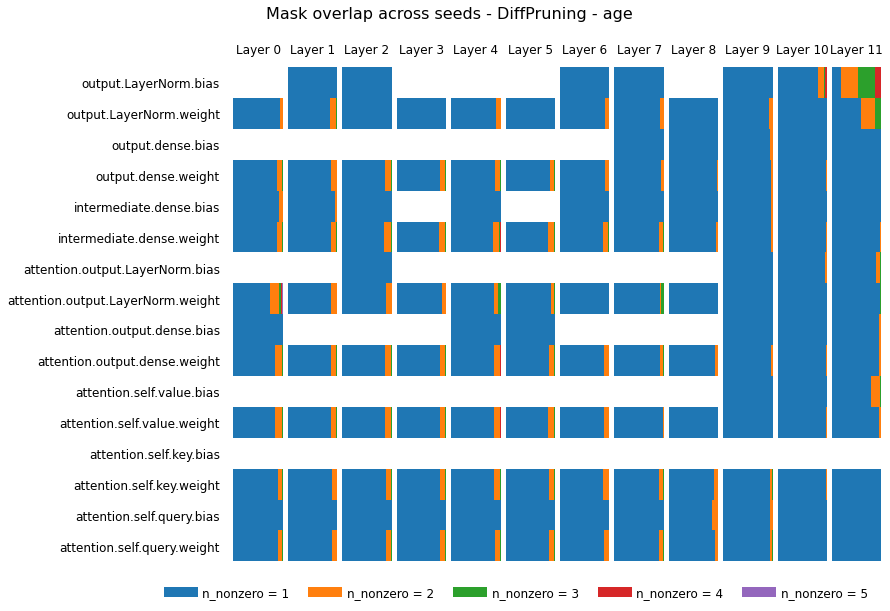

In [243]:
title = f"Mask overlap across seeds - {model_cat} - {prot_attr}"
filename = f"mask_overlap_{model_cat.lower()}_{prot_attr}.png"

title_fontsize = 16
text_fontsize = 12

shares_dict_layer_x = {k:v for k,v in shares_dict.items() if k[:14]=="encoder.layer."}
n_layers = max([int(k.split(".")[2]) for k in shares_dict_layer_x]) + 1

y_coord = np.arange(len(shares_dict_layer_x) // n_layers)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

fig, axs = plt.subplots(1, n_layers, figsize=(15, 10))
for layer_idx, ax in enumerate(axs):
    d = {".".join(k.split(".")[3:]):v for k,v in shares_dict_layer_x.items() if int(k.split(".")[2])==layer_idx}

    start = 0
    for i in range(5):
        v = np.array([x[i] for x in d.values()])
        ax.barh(y_coord, v, height=1, left=start, color=colors[i])
        start += v

    if layer_idx==0:
        ax.set_yticks(y_coord, d.keys(), fontsize=text_fontsize)
        ax.tick_params(axis="y", left=False, pad=10)
    else:
        ax.set_yticks([])
    ax.set_xticks([])
    
    ax.set_title(f"Layer {layer_idx}", fontsize=text_fontsize, y=.97)
sns.despine(left=True, bottom=True, right=True)

custom_lines = [Line2D([0], [0], color=c, lw=10) for c in colors]
plt.legend(custom_lines, [f"n_nonzero = {i}" for i in range(1,6)], ncol=5, bbox_to_anchor=(0.95, 0.02), frameon=False, fontsize=text_fontsize)

plt.suptitle(title, y=.93, fontsize=title_fontsize)
plt.subplots_adjust(left=0.3, wspace=0.1)
if savefigs:
    plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight')
plt.show()

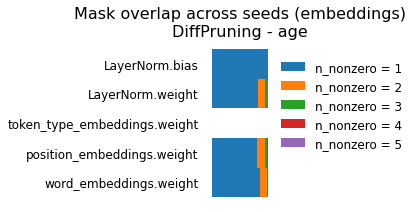

In [244]:
title = f"Mask overlap across seeds (embeddings)\n{model_cat} - {prot_attr}"
filename = f"mask_overlap_embeddings_{model_cat.lower()}_{prot_attr}.png"

title_fontsize = 16
text_fontsize = 12

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

shares_dict_layer_x = {k:v for k,v in shares_dict.items() if k[:10]=="embeddings"}
y_coord = np.arange(len(shares_dict_layer_x))
d = {".".join(k.split(".")[1:]):v for k,v in shares_dict_layer_x.items() }

plt.figure(figsize=(1, 3))
start = 0
for i in range(5):
    v = np.array([x[i] for x in d.values()])
    plt.barh(y_coord, v, height=1, left=start, color=colors[i])
    start += v

plt.yticks(y_coord, d.keys(), fontsize=text_fontsize)
plt.tick_params(axis="y", left=False, pad=10)
plt.xticks([])
    
sns.despine(left=True, bottom=True, right=True)

plt.legend([f"n_nonzero = {i}" for i in range(1,6)], bbox_to_anchor=(1.05, 0.95), fontsize=text_fontsize, frameon=False)

plt.title(title, fontsize=title_fontsize)
if savefigs:
    plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight')
plt.show()

#### Analyze tokens

In [245]:
tokenizer = AutoTokenizer.from_pretrained(model.model_name)

In [246]:
word_emb = diff_weights['embeddings.word_embeddings.weight'].sum(0)
token_ids = (word_emb > 2).nonzero()[:,0].unique()
tokens = tokenizer.convert_ids_to_tokens(token_ids)
words = sorted([s for s in tokens if len(re.sub("[^\w]", "", s))>3], key=lambda x: len(x), reverse=True)

In [247]:
for word in words:
    print(word)

entrepreneurs
presentation
entrepreneur
unemployment
information
environment
opportunity
interesting
advertising
inspiration
everything
technology
conference
basketball
apparently
psychology
enterprise
##fication
something
education
important
companies
beautiful
christmas
interview
marketing
corporate
followers
wednesday
delicious
analytics
building
business
research
students
anything
magazine
actually
everyone
personal
thinking
location
remember
problems
projects
accepted
software
learning
analysis
internet
yourself
tomorrow
breaking
saturday
colorado
creative
birthday
shopping
customer
workshop
download
facebook
gorgeous
semantic
##tagram
through
because
another
thought
without
service
country
support
already
working
present
looking
someone
project
finally
playing
running
episode
friends
morning
getting
believe
writing
##ville
feeling
success
manager
waiting
windows
article
reading
perfect
tonight
account
leaders
content
calling
reviews
economy
weather
showing
climate
writers
session